In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx 
import optax
import matplotlib.pyplot as plt

from gstools import SRF, Gaussian
from gstools.random import MasterRNG
from utils_fdm import *

In [2]:
#PARAMETROS DO MODELO
D = 0.0039
P = 0.0453
C0 = 8e3
ALPHA = 0.0305
AB = 10

#DOMINIO DO MODELO
L = 20
TF = 80

#QUANTIDADE DE NÓS DO DOMÍNIO
N_X = 50
N_T = TF

#PLANO DE TRATAMENTO DIAS X DOSES
DAYS = [
    [],
    [0,1], # Um dia +1 da dose extra
    [i for i in range(6)], # Dois dias +1 da dose extra
    [i for i in range(21)],
    [i for i in range(28)],
    [i for i in range(35)]
]
DOSES = [
    [],
    [60.0, 4.2],
    [12.2, 12.2, 12.2, 12.2, 12.2, 3.2],
    [2.8, 2.8, 2.8, 2.8, 2.8, 0.0, 0.0, 3.5, 3.5, 3.5, 3.5, 3.5, 0.0, 0.0, 6.5, 6.5, 6.5, 6.5, 6.5, 0.0, 0.0],
    [2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.9, 2.9, 2.9, 2.9, 2.9, 0.0, 0.0, 3.0, 3.0, 3.0, 3.0, 3.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0],
    [1.8, 1.8, 1.8, 1.8, 1.8, 0.0, 0.0, 1.8, 1.8, 1.8, 1.8, 1.8, 0.0, 0.0, 1.8, 1.8, 1.8, 1.8, 1.8, 0.0, 0.0, 1.8, 1.8, 1.8, 1.8, 1.8, 0.0, 0.0, 1.8, 1.8, 1.8, 1.8, 1.8, 0.0, 0.0]
]

#DICIONÁRIO DOS PARÂMETROS
PARAMS = Params(D, P, L, TF, C0, ALPHA, AB)

#VARIAVEIS E CONDIÇÃO INICIAL
X = np.linspace(0, 1, N_X, dtype = np.float32) 
T = np.linspace(0, PARAMS['tf'] * PARAMS['p'], N_T) 

#PROCESSO GAUSSIANO
seed = MasterRNG(123)
def Random_functions(x):
    model = Gaussian(dim=1, var=50, len_scale=0.6)
    srf= SRF(model, seed=seed())
    f = srf.structured([x])
    return f

#CONDIÇÕES INICIAIS ALEATÓRIAS VIA PROCESSO GAUSSIANO
N_ICS = 250
ICS = np.zeros((N_ICS, N_X))
for fn in range(N_ICS):
    x_values = Random_functions(X)
    ICS[fn, :] = x_values

# GERANDO SOLUÇÕES PARA DIFERENTES CONDIÇÕES INICIAIS
S = []
for i in range(N_ICS):
    X, T, SOLUTION = Solve(DAYS[0], DOSES[0], PARAMS, X, T, ICS[i], False, 40)
    S.append(SOLUTION)

S = np.array(S)
S = S * (C0 / L**3)

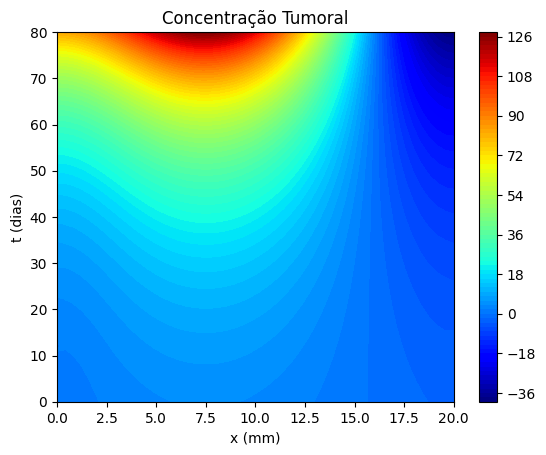

In [3]:
plt.contourf(X * L, T / P, S[2], 100, cmap = 'jet')
plt.colorbar()
plt.xlabel('x (mm)')
plt.ylabel('t (dias)')
plt.title('Concentração Tumoral')
plt.show()

In [4]:
# CONSTRUÇÃO DA BASE DE DADOS

# BRANCH DATA
branch = ICS

# TRUNK DATA
trunk = []
for i in T:
    for j in X: 
        trunk.append([i, j])

trunk = jnp.array(trunk)

# TARGET DATA
target = []
for i in range(len(ICS)):
    target.append(S[i].flatten())

target = jnp.array(target)

branch.shape, trunk.shape, target.shape

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


((250, 50), (4000, 2), (250, 4000))

In [5]:
class DeepONet(eqx.Module):

    branch__net: eqx.nn.MLP
    trunk__net: eqx.nn.MLP
    bias: jax.Array

    def __init__(
            self,
            input_branch,
            neurons,
            num_layers,
            interact_size,
            activation,
            *,
            key
    ):
        
        b_key, t_key = jr.split(key)
        self.branch__net = eqx.nn.MLP(
            in_size = input_branch,
            out_size = interact_size,
            width_size = neurons,
            depth = num_layers,
            activation = activation,
            key = b_key,
        )
        self.trunk__net = eqx.nn.MLP(
            in_size = 2,
            out_size = interact_size,
            width_size = neurons,
            depth = num_layers,
            activation = activation,
            key = t_key,
        )
        self.bias = jnp.zeros((1,))

    def __call__(
            self,
            x_branch,
            x_trunk
    ):
        out_b = self.branch__net(x_branch)
        out_t = self.trunk__net(x_trunk)
        inner_prod = jnp.sum(out_b * out_t, keepdims=True)

        return (inner_prod + self.bias)[0]
    

In [6]:
model = DeepONet(
    input_branch = N_X,
    neurons = 150,
    num_layers = 3,
    interact_size = 40,
    activation = jax.nn.relu,
    key = jr.PRNGKey(0),
)

optim = optax.adam(1e-3)
state = optim.init(
    eqx.filter(model, eqx.is_array)
)

def loss_fn(model):

    pred = jax.vmap(
        jax.vmap(
            model,
            in_axes=(None, 0)
        ),
        in_axes=(0, None)
    )(branch, trunk)

    mse = jnp.mean(jnp.square(pred - target))
    return mse

@eqx.filter_jit
def update_fn(model, state):

    loss, grad = eqx.filter_value_and_grad(loss_fn)(model)
    updates, new_states = optim.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)

    return new_model, new_states, loss

loss_history = []
epochs = 30000

for ep in range(epochs):

    model, state, loss = update_fn(
        model,
        state,
    )
    loss_history.append(loss)

    if ep % 1000 == 0: 
        print(f'Iteration: {ep}/{epochs}    Loss: {loss}')    

Iteration: 0/30000    Loss: 10332.2177734375
Iteration: 1000/30000    Loss: 5.1413164138793945
Iteration: 2000/30000    Loss: 10.853856086730957
Iteration: 3000/30000    Loss: 3.9294540882110596
Iteration: 4000/30000    Loss: 3.2239222526550293
Iteration: 5000/30000    Loss: 3.3053886890411377
Iteration: 6000/30000    Loss: 3.590916395187378
Iteration: 7000/30000    Loss: 2.4936182498931885
Iteration: 8000/30000    Loss: 0.37307918071746826
Iteration: 9000/30000    Loss: 0.20765824615955353
Iteration: 10000/30000    Loss: 0.16424058377742767
Iteration: 11000/30000    Loss: 2.849454879760742
Iteration: 12000/30000    Loss: 0.12604176998138428
Iteration: 13000/30000    Loss: 0.22312909364700317
Iteration: 14000/30000    Loss: 0.14839334785938263
Iteration: 15000/30000    Loss: 0.09983924776315689
Iteration: 16000/30000    Loss: 5.748522758483887
Iteration: 17000/30000    Loss: 0.17677558958530426
Iteration: 18000/30000    Loss: 7.838150978088379
Iteration: 19000/30000    Loss: 0.14716918

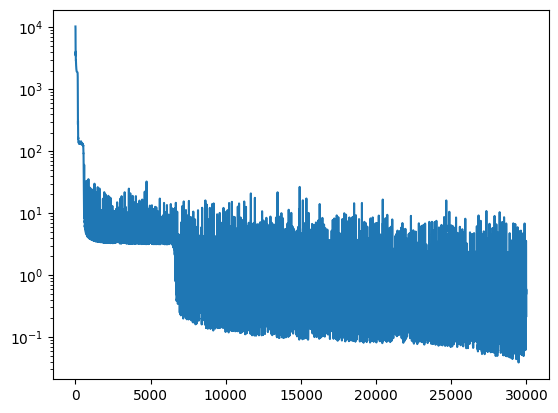

In [7]:
plt.plot(loss_history)
plt.yscale('log')   

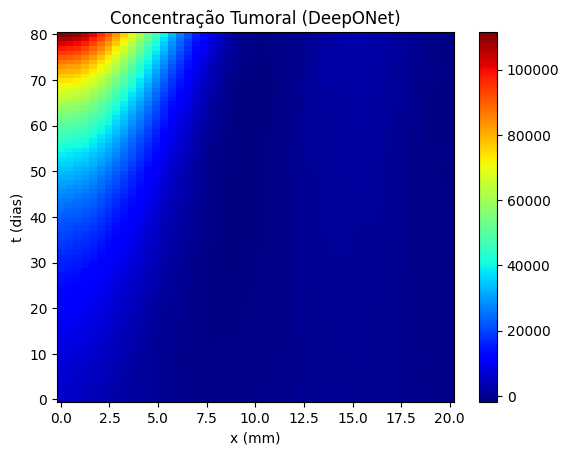

In [8]:
IC = L**3 * jnp.exp(-100 * X**2)

SOLUTION = jax.vmap(model, in_axes=(None, 0))(IC, trunk)
SOLUTION_DON = SOLUTION.reshape(N_T, N_X)
#SOLUTION.shape

#plt.imshow(SOLUTION.T, cmap = 'jet')
#plt.colorbar()

plt.pcolormesh(X * L, T / P, SOLUTION_DON, cmap = 'jet')
plt.colorbar()
plt.xlabel('x (mm)')
plt.ylabel('t (dias)')
plt.title('Concentração Tumoral (DeepONet)')
plt.show()

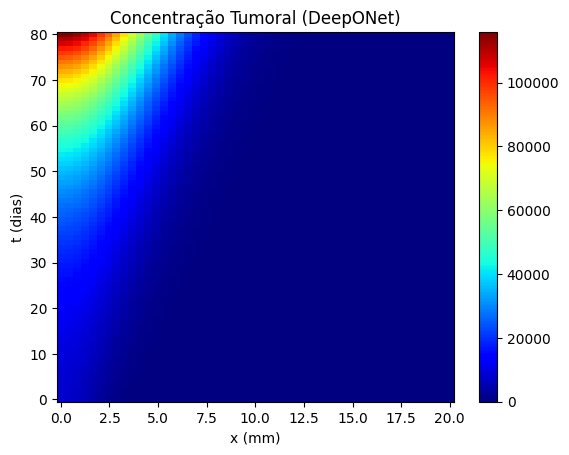

In [9]:
X, T, SOLUTION_FDM = Solve(DAYS[0], DOSES[0], PARAMS, X, T, IC, False, 40)

plt.pcolormesh(X * L, T / P, SOLUTION_FDM, cmap = 'jet')
plt.colorbar()
plt.xlabel('x (mm)')
plt.ylabel('t (dias)')
plt.title('Concentração Tumoral (DeepONet)')
plt.show()

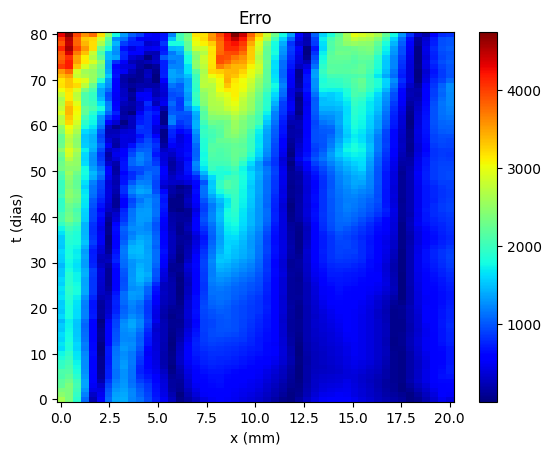

In [10]:
plt.pcolormesh(X * L, T / P, jnp.abs(SOLUTION_DON - SOLUTION_FDM), cmap = 'jet')
#plt.contourf(X * L, T / P, SOLUTION_DON - SOLUTION_FDM, 100, cmap = 'jet')
plt.colorbar()
plt.xlabel('x (mm)')
plt.ylabel('t (dias)')
plt.title('Erro')
plt.show()

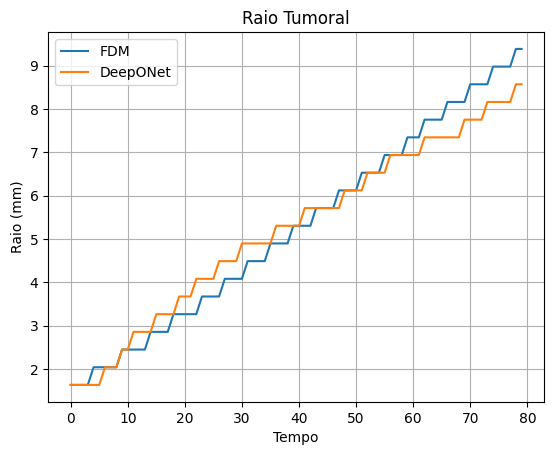

In [11]:
raio_fdm = Tumor_radius(SOLUTION_FDM, X, N_X, N_T, PARAMS)
raio_don = Tumor_radius(SOLUTION_DON, X, N_X, N_T, PARAMS)

plt.plot(raio_fdm, label = 'FDM')
plt.plot(raio_don, label = 'DeepONet')
plt.title('Raio Tumoral')
plt.xlabel('Tempo')
plt.ylabel('Raio (mm)')
plt.legend()
plt.grid()


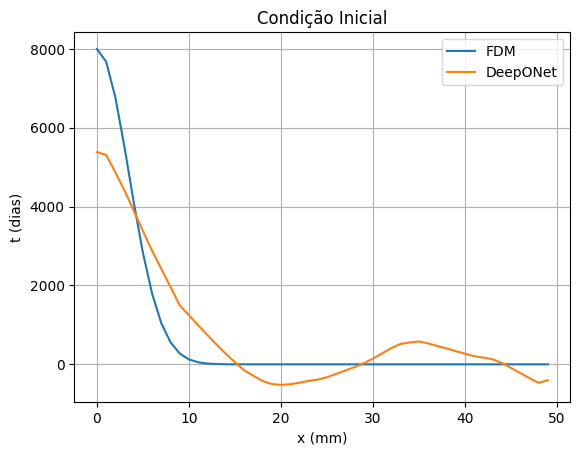

In [12]:
plt.plot(SOLUTION_FDM[0], label = 'FDM')
plt.plot(SOLUTION_DON[0], label = 'DeepONet')
plt.title('Condição Inicial')
plt.xlabel('x (mm)')
plt.ylabel('t (dias)')
plt.legend()
plt.grid()

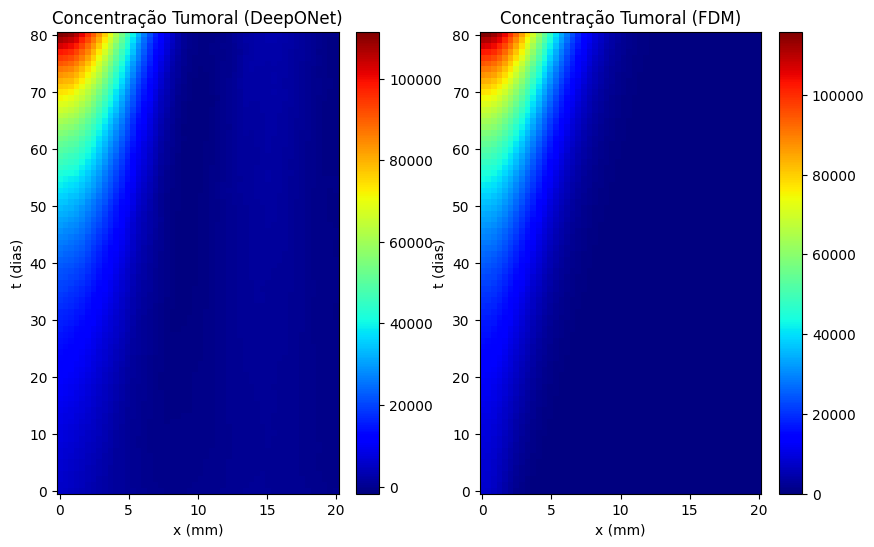

In [13]:
figure, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize = (10, 6))
plot1 = ax1.pcolormesh(X * L, T / P, SOLUTION_DON, cmap = 'jet')
ax1.set_xlabel('x (mm)')
ax1.set_ylabel('t (dias)')
ax1.set_title('Concentração Tumoral (DeepONet)')
plot2 = ax2.pcolormesh(X * L, T / P, SOLUTION_FDM, cmap = 'jet')
ax2.set_xlabel('x (mm)')
ax2.set_ylabel('t (dias)')
ax2.set_title('Concentração Tumoral (FDM)')

plt.colorbar(plot1)
plt.colorbar(plot2)
plt.show()

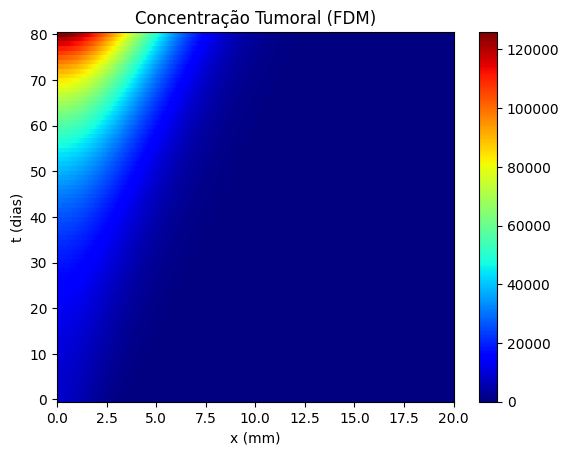

In [14]:
# UP-SCALLING
NEW_X = jnp.linspace(0, 1, 10000, dtype = jnp.float32)
NEW_IC = L**3 * jnp.exp(-100 * NEW_X**2)
X, T, NEW_SOLUTION_FDM = Solve(DAYS[0], DOSES[0], PARAMS, NEW_X, T, NEW_IC, False, 40)

plt.pcolormesh(NEW_X * L, T / P, NEW_SOLUTION_FDM, cmap = 'jet')
plt.colorbar()
plt.xlabel('x (mm)')
plt.ylabel('t (dias)')
plt.title('Concentração Tumoral (FDM)')
plt.show()

In [15]:
trunk = []
for i in T:
    for j in NEW_X: 
        trunk.append([i, j])

new_trunk = jnp.array(trunk)

: 

In [16]:
SOLUTION = jax.vmap(model, in_axes=(None, 0))(IC, new_trunk)
NEW_SOLUTION_DON = SOLUTION.reshape(N_T, N_X)

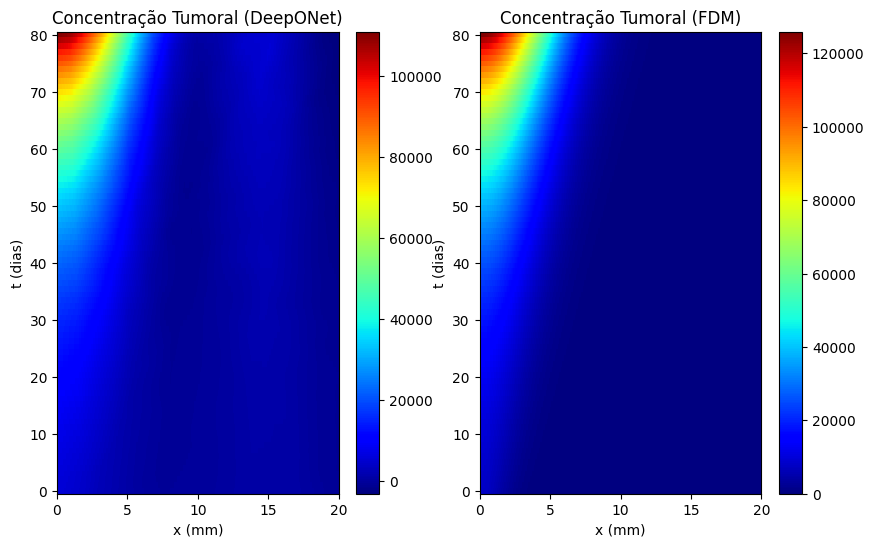

: 

In [25]:
figure, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize = (10, 6))
plot1 = ax1.pcolormesh(NEW_X * L, T / P, NEW_SOLUTION_DON, cmap = 'jet')
ax1.set_xlabel('x (mm)')
ax1.set_ylabel('t (dias)')
ax1.set_title('Concentração Tumoral (DeepONet)')
plot2 = ax2.pcolormesh(NEW_X * L, T / P, NEW_SOLUTION_FDM, cmap = 'jet')
ax2.set_xlabel('x (mm)')
ax2.set_ylabel('t (dias)')
ax2.set_title('Concentração Tumoral (FDM)')

plt.colorbar(plot1)
plt.colorbar(plot2)
plt.show()

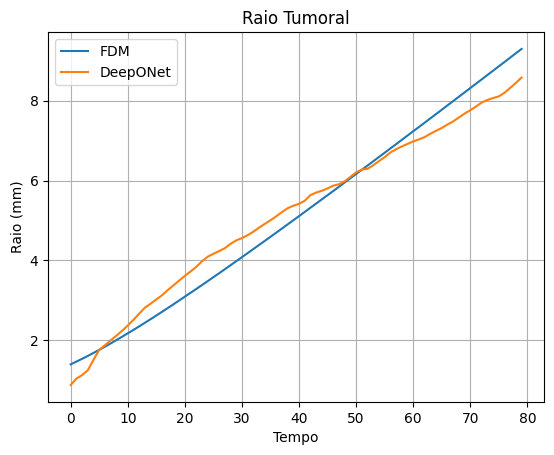

In [24]:
raio_fdm = Tumor_radius(NEW_SOLUTION_FDM, NEW_X, len(NEW_X), N_T, PARAMS)
raio_don = Tumor_radius(NEW_SOLUTION_DON, NEW_X, len(NEW_X), N_T, PARAMS)

plt.plot(raio_fdm, label = 'FDM')
plt.plot(raio_don, label = 'DeepONet')
plt.title('Raio Tumoral')
plt.xlabel('Tempo')
plt.ylabel('Raio (mm)')
plt.legend()
plt.grid()


In [5]:
#CONDIÇÕES INICIAIS ALEATÓRIAS VIA PROCESSO GAUSSIANO
N_ICS = 250
ICS = np.zeros((N_ICS, N_X))
for fn in range(N_ICS):
    x_values = Random_functions(X)
    ICS[fn, :] = x_values

# GERANDO SOLUÇÕES PARA DIFERENTES CONDIÇÕES INICIAIS
S = []
for i in range(N_ICS):
    X, T, SOLUTION = Solve(DAYS[0], DOSES[0], PARAMS, X, T, ICS[i], False, 40)
    S.append(SOLUTION)

S = np.array(S)

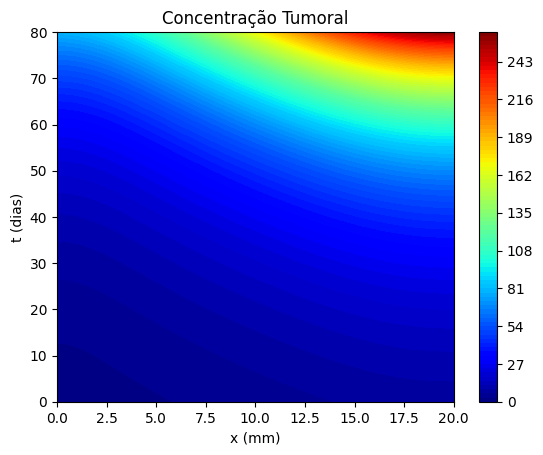

In [7]:
plt.contourf(X * L, T / P, S[0], 100, cmap = 'jet')
plt.colorbar()
plt.xlabel('x (mm)')
plt.ylabel('t (dias)')
plt.title('Concentração Tumoral')
plt.show()

In [33]:
L = 2

x = jnp.linspace(0, 1, 1000)
ic = L**3 * jnp.exp(-100 * x**2)
X, T, SOLUTION = Solve(DAYS[0], DOSES[0], PARAMS, x, T, ic, False, 40)

c = C0 / L**3
c

1000.0

In [34]:
SOLUTION * c

array([[8.00000000e+03, 7.99919844e+03, 7.99679422e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.09083082e+03, 8.09007455e+03, 8.08780525e+03, ...,
        9.35183877e-29, 9.20079123e-29, 9.15044206e-29],
       [8.20109999e+03, 8.20038160e+03, 8.19822694e+03, ...,
        4.67666553e-27, 4.60417163e-27, 4.58000700e-27],
       ...,
       [1.07236834e+05, 1.07235184e+05, 1.07230234e+05, ...,
        4.79405333e-02, 4.78757795e-02, 4.78541949e-02],
       [1.11658911e+05, 1.11657212e+05, 1.11652114e+05, ...,
        5.88862355e-02, 5.88084074e-02, 5.87824647e-02],
       [1.16270213e+05, 1.16268463e+05, 1.16263211e+05, ...,
        7.20827534e-02, 7.19895124e-02, 7.19584321e-02]])

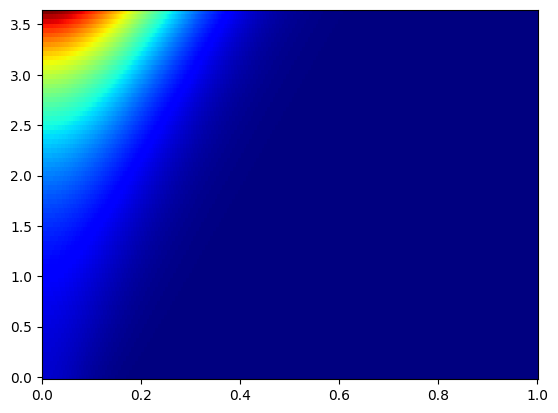

In [35]:
plt.pcolormesh(x, T, SOLUTION * c, cmap = 'jet')